In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775





<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:11<00:00, 1226.09it/s]


In [24]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [25]:
final["UPDATEDTEXT"]=preprocessed_reviews

In [26]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [27]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,UPDATEDTEXT
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...


In [28]:
final['text_len'] = final['UPDATEDTEXT'].str.len()

In [29]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...,277


In [30]:
df=pd.DataFrame(final)

In [31]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...,277


In [32]:
df.drop("Text",axis = 1, inplace = True)

In [33]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,wish would read reviews making purchase basica...,277
70673,76866,B00002N8SM,A3R3T5T1K8IN6P,LILIAN J. DE CIAFFI,0,0,1,1315785600,THIS ITEM IS EXCELLENT TO KILL INSECTS,happy item many flies disturbing kitchen put p...,84
70672,76865,B00002N8SM,A11DU8T1ZXPRT7,Zoggdogg,0,0,0,1319241600,Didn't work,thing item trapped fruit flies not work fly tr...,68
70671,76864,B00002N8SM,A71C9WY0242QU,MeMeMe,0,0,1,1325376000,Gross but effective,nurturing plant work well decided repot larger...,495
70670,76863,B00002N8SM,A17UIV0KM8JSV,S. Cohen,0,0,0,1337644800,Didn't work for me.,placed around house several days setup fly att...,255
70669,76862,B00002N8SM,A5W8ZREO7C1WK,Mireille,0,0,0,1340582400,Waste of money,please not waste money fly trap absolutely use...,196


In [34]:
Y1=df["Score"].values

In [35]:
df.drop("Score",axis = 1, inplace = True)

In [36]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,1192060800,made in china,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1195948800,Dog Lover Delites,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,1288396800,only one fruitfly stuck,infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,1290038400,Doesn't work!! Don't waste your money!!,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,1306972800,A big rip off,wish would read reviews making purchase basica...,277
70673,76866,B00002N8SM,A3R3T5T1K8IN6P,LILIAN J. DE CIAFFI,0,0,1315785600,THIS ITEM IS EXCELLENT TO KILL INSECTS,happy item many flies disturbing kitchen put p...,84
70672,76865,B00002N8SM,A11DU8T1ZXPRT7,Zoggdogg,0,0,1319241600,Didn't work,thing item trapped fruit flies not work fly tr...,68
70671,76864,B00002N8SM,A71C9WY0242QU,MeMeMe,0,0,1325376000,Gross but effective,nurturing plant work well decided repot larger...,495
70670,76863,B00002N8SM,A17UIV0KM8JSV,S. Cohen,0,0,1337644800,Didn't work for me.,placed around house several days setup fly att...,255
70669,76862,B00002N8SM,A5W8ZREO7C1WK,Mireille,0,0,1340582400,Waste of money,please not waste money fly trap absolutely use...,196


In [37]:
df1=df.drop(df.columns[[0,1,2,3,4,5,6,7]],axis=1)

In [38]:
df1.head()

,UPDATEDTEXT,text_len
22620,dogs loves chicken product china wont buying a...,162
22621,dogs love saw pet store tag attached regarding...,72
70677,infestation fruitflies literally everywhere fl...,406
70676,worst product gotten long time would rate no s...,209
70675,wish would read reviews making purchase basica...,277


In [39]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(df1, Y1, test_size=0.2, shuffle=False)
X1_train, X1_cv, Y1_train, Y1_cv = train_test_split(X1_train, Y1_train, test_size=0.2,shuffle=False)

In [40]:
print(X1_train.shape, Y1_train.shape)
print(X1_cv.shape, Y1_cv.shape)
print(X1_test.shape, Y1_test.shape)

(56174, 2) (56174,)
(14044, 2) (14044,)
(17555, 2) (17555,)


In [41]:
X1_train["UPDATEDTEXT"]

22620    dogs loves chicken product china wont buying a...
22621    dogs love saw pet store tag attached regarding...
70677    infestation fruitflies literally everywhere fl...
70676    worst product gotten long time would rate no s...
70675    wish would read reviews making purchase basica...
70673    happy item many flies disturbing kitchen put p...
70672    thing item trapped fruit flies not work fly tr...
70671    nurturing plant work well decided repot larger...
70670    placed around house several days setup fly att...
70669    please not waste money fly trap absolutely use...
70668    let put way flies stay traps left looks like s...
70661    not know product performs big flies sucks frui...
70667    flies buzz around thing like not even many fli...
70666    horrible product first item not work week lots...
70665    never caught even one fly got inside left week...
70662    ineffective worthless bought product indoors t...
70663    problem lot fruit flies kitchen picked one tak.

## [1] BOW

In [42]:
count_vect = CountVectorizer(ngram_range = (1,2),min_df=10)
X_train_BOW = count_vect.fit_transform(X1_train["UPDATEDTEXT"])
X_train_BOW.shape

(56174, 32777)

In [43]:
X_cv_BOW = count_vect.transform(X1_cv["UPDATEDTEXT"])
X_cv_BOW.shape

(14044, 32777)

In [44]:
X_test_BOW = count_vect.transform(X1_test["UPDATEDTEXT"])
X_test_BOW.shape

(17555, 32777)

In [45]:
from sklearn.preprocessing import StandardScaler
X_train_bow=StandardScaler(with_mean=False).fit_transform(X_train_BOW)
X_cv_bow=StandardScaler(with_mean=False).fit_transform(X_cv_BOW)
X_test_bow=StandardScaler(with_mean=False).fit_transform(X_test_BOW)
print(X_train_bow.shape, Y1_train.shape) 
print(X_cv_bow.shape, Y1_cv.shape)
print(X_test_bow.shape, Y1_test.shape) 

(56174, 32777) (56174,)
(14044, 32777) (14044,)
(17555, 32777) (17555,)


## L1 regularization on BOW

1e-05   -5.0 -----> 0.5
0.0001   -4.0 -----> 0.5
0.001   -3.0 -----> 0.8804660452215939
0.01   -2.0 -----> 0.9554244360372083
0.1   -1.0 -----> 0.9439465681712538
1   0.0 -----> 0.9350831096514016
10   1.0 -----> 0.9290742663677967
100   2.0 -----> 0.9170570305359507
1000   3.0 -----> 0.9079840341601153
10000   4.0 -----> 0.9039450666816092


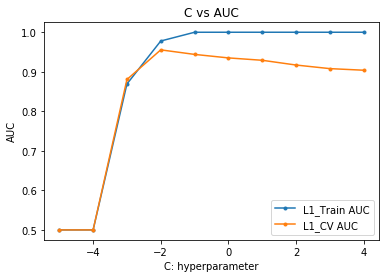

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score 
train_auc_l1 = [] 
cv_auc_l1 = []
    

C=[10**i for i in range(-5,5)]
for j in C:
    LogR = LogisticRegression(C=j, penalty= "l1")
    LogR.fit(X_train_bow, Y1_train)
    y_train_pred = LogR.predict_proba(X_train_bow)[:,1] 
    y_cv_pred =  LogR.predict_proba(X_cv_bow)[:,1]
    
    train_auc_score=roc_auc_score(Y1_train,y_train_pred)
    train_auc_l1.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, y_cv_pred)
    print(j," ",np.log10(j),"----->",cv_auc_score)
    cv_auc_l1.append(cv_auc_score)
    
    
plt.plot(np.log10(C), train_auc_l1, label='L1_Train AUC',marker = '.') 
plt.plot(np.log10(C), cv_auc_l1, label='L1_CV AUC',marker = '.')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("C vs AUC")
plt.show()
   

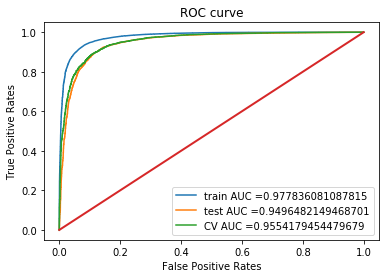

In [47]:
from sklearn.metrics import roc_curve, auc


LogRm = LogisticRegression(C=0.01, penalty= "l1")
LogRm.fit(X_train_bow, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(Y1_train, LogRm.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, LogRm.predict_proba(X_test_bow)[:,1])
cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,LogRm.predict_proba(X_cv_bow)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

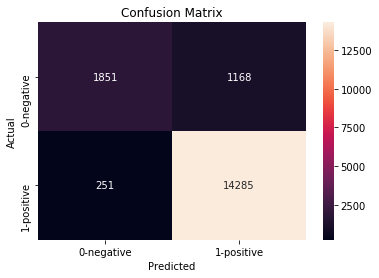

In [48]:
import seaborn as sb
C_b = confusion_matrix(Y1_test,LogRm.predict(X_test_bow))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


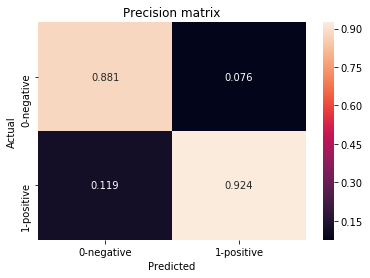

In [49]:
B_b =(C_b/C_b.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

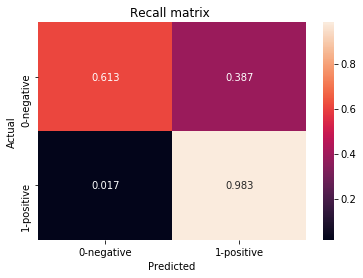

In [50]:
A_b =(((C_b.T)/(C_b.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Sparsity on weight vector obtained using L1 regularization on BOW

In [51]:
logr = LogisticRegression(C=0.001, penalty='l1')
logr.fit(X_train_bow, Y1_train)
w = logr.coef_
print(np.count_nonzero(w))

72


In [52]:
logr = LogisticRegression(C=0.01, penalty='l1')
logr.fit(X_train_bow, Y1_train)
w = logr.coef_
print(np.count_nonzero(w))

2775


In [53]:
logr = LogisticRegression(C=0.1, penalty='l1')
logr.fit(X_train_bow, Y1_train)
w = logr.coef_
print(np.count_nonzero(w))

9693


In [54]:
logr = LogisticRegression(C=1, penalty='l1')
logr.fit(X_train_bow, Y1_train)
w = logr.coef_
print(np.count_nonzero(w))

11551


Observation:<br>
1]As hyperparameter C increases sparsity decreases.<br>
2]For optimal hyperparameter which is 0.01 the sparsity is 2777.<br>

## L2 regularization on BOW

C   log10(C) -----> CV AUC SCORE
----------------------------------------------------
1e-05   -5.0 -----> 0.8716917601861414
0.0001   -4.0 -----> 0.9363053236642304
0.001   -3.0 -----> 0.9366506590706579
0.01   -2.0 -----> 0.9287891492059901
0.1   -1.0 -----> 0.9226081971310225
1   0.0 -----> 0.9169096040131168
10   1.0 -----> 0.9082572879671436
100   2.0 -----> 0.8988810548678716
1000   3.0 -----> 0.8951982224151129
10000   4.0 -----> 0.8953817979141339


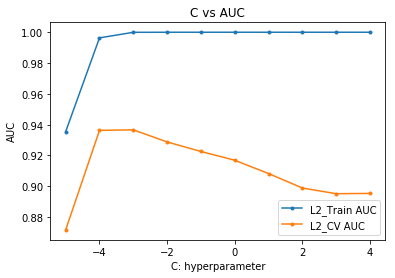

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score 
train_auc_l2 = [] 
cv_auc_l2 = []
print("C"," ","log10(C)","----->","CV AUC SCORE")
print("----------------------------------------------------")    

C=[10**i for i in range(-5,5)]
for j in C:
    LogR12 = LogisticRegression(C=j, penalty= "l2")
    LogR12.fit(X_train_bow, Y1_train)
    y_train_pred = LogR12.predict_proba(X_train_bow)[:,1] 
    y_cv_pred =  LogR12.predict_proba(X_cv_bow)[:,1]
    
    train_auc_score=roc_auc_score(Y1_train,y_train_pred)
    train_auc_l2.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, y_cv_pred)
    print(j," ",np.log10(j),"----->",cv_auc_score)
    cv_auc_l2.append(cv_auc_score)
    
    
plt.plot(np.log10(C), train_auc_l2, label='L2_Train AUC',marker = '.') 
plt.plot(np.log10(C), cv_auc_l2, label='L2_CV AUC',marker = '.')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("C vs AUC")
plt.show()

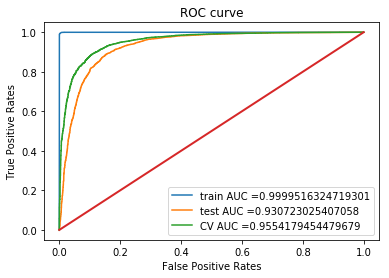

In [56]:
from sklearn.metrics import roc_curve, auc


LogRm12 = LogisticRegression(C=0.001, penalty= "l2")
LogRm12.fit(X_train_bow, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(Y1_train, LogRm12.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, LogRm12.predict_proba(X_test_bow)[:,1])
cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,LogRm.predict_proba(X_cv_bow)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

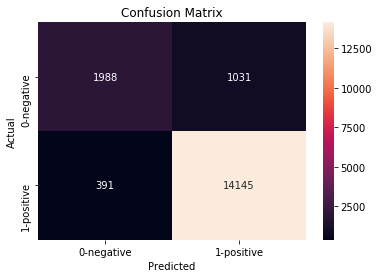

In [57]:
import seaborn as sb
C_b12 = confusion_matrix(Y1_test,LogRm12.predict(X_test_bow))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_b12, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

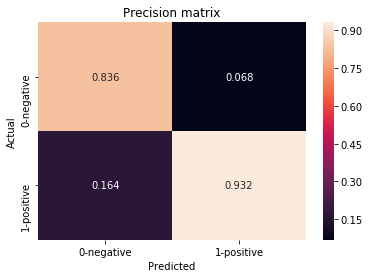

In [58]:
B_b12 =(C_b12/C_b12.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_b12, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

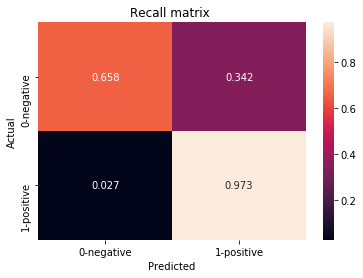

In [59]:
A_b12 =(((C_b12.T)/(C_b12.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_b12, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Observations:<br>
1] For BOW L1 regularization we got Test Auc of 94.96.<br>
2] For L2 regularization we got Test Auc of 93.07.<br>

## PERTUBATION TEST

In [60]:
import copy
x_train_noise=copy.deepcopy(X_train_bow)
ep=np.random.normal(0,0.001)
x_train_noise.data += ep
print(x_train_noise.shape)

(56174, 32777)


In [61]:
weight1=LogRm.coef_
print(weight1.shape)

(1, 32777)


In [62]:
lr = LogisticRegression(C= 0.01, penalty= 'l1')
lr.fit(x_train_noise,Y1_train)
weight2=lr.coef_
print(weight2.shape)

(1, 32777)


In [63]:
ePS=np.random.normal(0,0.001)
weight1+=ePS
weight2+=ePS

In [64]:
per_weight_difference = np.abs((weight2-weight1)/weight1)*100

In [65]:
per_weight_difference

array([[0., 0., 0., ..., 0., 0., 0.]])

In [66]:
per_weight_difference_sort=np.sort(per_weight_difference)
per_weight_difference_sindex=np.argsort(per_weight_difference)

In [67]:
for i in (np.arange(0,91,10)):
    print('Difference b/w {0} percentile and {1} percentile is {2}'.format(i,i+10,abs(np.percentile(per_weight_difference_sort,[i])-np.percentile(per_weight_difference_sort,[i+10]))))

Difference b/w 0 percentile and 10 percentile is [0.]
Difference b/w 10 percentile and 20 percentile is [0.]
Difference b/w 20 percentile and 30 percentile is [0.]
Difference b/w 30 percentile and 40 percentile is [0.]
Difference b/w 40 percentile and 50 percentile is [0.]
Difference b/w 50 percentile and 60 percentile is [0.]
Difference b/w 60 percentile and 70 percentile is [0.]
Difference b/w 70 percentile and 80 percentile is [0.]
Difference b/w 80 percentile and 90 percentile is [0.]
Difference b/w 90 percentile and 100 percentile is [403.92089103]


In [68]:
for i in (np.arange(91,100,1)):
    print('Difference b/w {0} percentile and {1} percentile is {2}'.format(i,i+1,abs(np.percentile(per_weight_difference_sort,[i])-np.percentile(per_weight_difference_sort,[i+1]))))

Difference b/w 91 percentile and 92 percentile is [0.00875149]
Difference b/w 92 percentile and 93 percentile is [0.02061355]
Difference b/w 93 percentile and 94 percentile is [0.02475527]
Difference b/w 94 percentile and 95 percentile is [0.03664393]
Difference b/w 95 percentile and 96 percentile is [0.05042155]
Difference b/w 96 percentile and 97 percentile is [0.09397868]
Difference b/w 97 percentile and 98 percentile is [0.21207403]
Difference b/w 98 percentile and 99 percentile is [0.65617306]
Difference b/w 99 percentile and 100 percentile is [402.81747947]


In [69]:
k=99
for i in range(1,12,1):
    w=np.percentile(per_weight_difference_sort,k)
    print("percentile {0} = {1}".format('%.2f'%k,w))
    k+=0.1

percentile 99.00 = 1.1034115564074398
percentile 99.10 = 1.2071919501827064
percentile 99.20 = 1.4475092733363364
percentile 99.30 = 1.6758334528066872
percentile 99.40 = 2.0696830945124334
percentile 99.50 = 2.513363578507352
percentile 99.60 = 2.9981841998859946
percentile 99.70 = 4.090460333841587
percentile 99.80 = 8.306225060357132
percentile 99.90 = 24.81997808137643
percentile 100.00 = 403.9208910274274


### We are considering threshold value of 99.8 because there is a large percentile change from point 99 to 99.8

In [70]:
feat=count_vect.get_feature_names()
required_feature=np.where(per_weight_difference_sort>np.percentile(per_weight_difference_sort,99.8))[1]

In [71]:
list=[]
for i in required_feature:
    list.append(feat[i])

In [72]:
print(len(list))

66


### Feature names whose % change is more than our threshold.

In [73]:
print(list)

['young old', 'younger', 'youngest', 'youth', 'youtube', 'yr', 'yr old', 'yrs', 'yrs old', 'yuban', 'yuban coffee', 'yuck', 'yuck not', 'yucky', 'yuk', 'yum', 'yum yum', 'yumm', 'yummier', 'yummiest', 'yummy', 'yummy also', 'yummy even', 'yummy good', 'yummy great', 'yummy healthy', 'yummy like', 'yummy no', 'yummy not', 'yummy taste', 'yummy treat', 'yup', 'zap', 'zatarain', 'zealand', 'zen', 'zero', 'zero calorie', 'zero calories', 'zero stars', 'zest', 'zesty', 'zico', 'zinc', 'zinc sulfate', 'zing', 'zip', 'zip lock', 'ziploc', 'ziploc bag', 'ziplock', 'ziplock bag', 'ziplock bags', 'zipper', 'zippy', 'ziwipeak', 'zojirushi', 'zone', 'zoo', 'zucchini', 'zuke', 'zuke hip', 'zuke mini', 'zuke treats', 'zukes', 'zukes mini']


In [74]:
per_weight = np.abs(weight2-weight1)

In [75]:
per_weight

array([[0., 0., 0., ..., 0., 0., 0.]])

In [76]:
per_weight_sort=np.sort(per_weight)[:,::-1]

In [77]:
per_weight_sort

array([[0.0146249 , 0.01460483, 0.00834115, ..., 0.        , 0.        ,
        0.        ]])

In [78]:
per_weight_difference_asort=np.sort(per_weight_difference)[:,::-1]

In [79]:
per_weight_difference_asort

array([[403.92089103, 398.04462912, 339.95172355, ...,   0.        ,
          0.        ,   0.        ]])

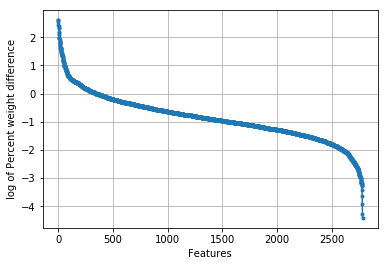

In [80]:
from matplotlib.pyplot import figure
plt.plot(np.arange(1,32778,1),np.log10(per_weight_difference_asort[0]),marker = '.')
#plt.xlim(plt.xlim()[::-1])
plt.grid()
plt.xlabel("Features")
plt.ylabel("log of Percent weight difference")


plt.show()

## Feature Importance on BOW

In [81]:
w_12=np.argsort(weight1)
w_12

array([[ 7281, 19145, 32308, ...,  2259, 12057, 12609]], dtype=int64)

In [82]:
w_12[0][::-1]

array([12609, 12057,  2259, ..., 32308, 19145,  7281], dtype=int64)

In [83]:
w_2=w_12[0][::-1]

In [84]:
w_2[:10]

array([12609, 12057,  2259,  6833, 16473, 16722, 21497,  8969, 32164,
       19302], dtype=int64)

In [85]:
features_name=count_vect.get_feature_names()

## Top 10 important features of Positive class 

In [86]:
for i in w_2[:10]:
    print("{0}   {1}".format(features_name[i],weight1[0][i]))

great   0.6148952945111567
good   0.4085989959380151
best   0.4084546214473668
delicious   0.3974922032902492
love   0.32344152926277087
loves   0.3219527275254585
perfect   0.28913735069258883
excellent   0.24501389493250578
wonderful   0.20941938849523917
not disappointed   0.19670963078773981


## Top 10 important features of Negative class 

In [87]:
for i in w_2[::-1][:10]:
    print("{0}   {1}".format(features_name[i],weight1[0][i]))

disappointed   -0.2680644798761127
not   -0.20806509899422165
worst   -0.18785036146454054
not good   -0.1781865474399209
not worth   -0.16616210328662429
not recommend   -0.16442219805331665
not buy   -0.14116176582096596
terrible   -0.13840450090585035
awful   -0.13719675460605227
bad   -0.13461842446819952


## [2] TFIDF

In [589]:
tf_idf_vect = TfidfVectorizer(min_df = 10, ngram_range = (1,2))
tf_idf_vect.fit(X1_train["UPDATEDTEXT"])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X1_train_tfidf = tf_idf_vect.transform(X1_train["UPDATEDTEXT"])
print("the type of count vectorizer ",type(X1_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X1_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X1_train_tfidf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'abandon', 'abdominal', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (56174, 32777)
the number of unique words including both unigrams and bigrams  32777


In [590]:
X1_cv_tfidf=tf_idf_vect.transform(X1_cv["UPDATEDTEXT"])
X1_cv_tfidf.shape


(14044, 32777)

In [591]:
X1_test_tfidf=tf_idf_vect.transform(X1_test["UPDATEDTEXT"])
X1_test_tfidf.shape

(17555, 32777)

In [592]:
X_train_tfidf=StandardScaler(with_mean=False).fit_transform(X1_train_tfidf)
X_cv_tfidf=StandardScaler(with_mean=False).fit_transform(X1_cv_tfidf)
X_test_tfidf=StandardScaler(with_mean=False).fit_transform(X1_test_tfidf)
print(X_train_tfidf.shape, Y1_train.shape) 
print(X_cv_tfidf.shape, Y1_cv.shape)
print(X_test_tfidf.shape, Y1_test.shape)

(56174, 32777) (56174,)
(14044, 32777) (14044,)
(17555, 32777) (17555,)


## L1 regularization on TFIDF

C   log10(C) -----> CV AUC SCORE
----------------------------------------------------
1e-05   -5.0 -----> 0.5
0.0001   -4.0 -----> 0.5
0.001   -3.0 -----> 0.8876638021893406
0.01   -2.0 -----> 0.9600614752554038
0.1   -1.0 -----> 0.9488366502227588
1   0.0 -----> 0.9427431588378081
10   1.0 -----> 0.9394026689086603
100   2.0 -----> 0.9228191773401702
1000   3.0 -----> 0.9115730956277623
10000   4.0 -----> 0.9119199455050128


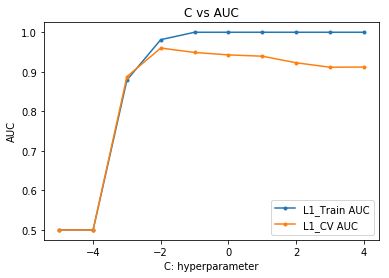

In [595]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score 
train_auc_l1 = [] 
cv_auc_l1 = []
print("C"," ","log10(C)","----->","CV AUC SCORE")
print("----------------------------------------------------")        

C=[10**i for i in range(-5,5)]
for j in C:
    LogRt = LogisticRegression(C=j, penalty= "l1")
    LogRt.fit(X_train_tfidf, Y1_train)
    y_train_pred = LogRt.predict_proba(X_train_tfidf)[:,1] 
    y_cv_pred =  LogRt.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc_score=roc_auc_score(Y1_train,y_train_pred)
    train_auc_l1.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, y_cv_pred)
    print(j," ",np.log10(j),"----->",cv_auc_score)
    cv_auc_l1.append(cv_auc_score)
    
    
plt.plot(np.log10(C), train_auc_l1, label='L1_Train AUC',marker = '.') 
plt.plot(np.log10(C), cv_auc_l1, label='L1_CV AUC',marker = '.')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("C vs AUC")
plt.show()

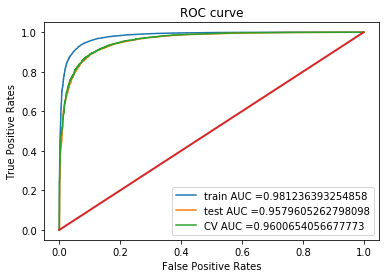

In [596]:
from sklearn.metrics import roc_curve, auc


LogRt1 = LogisticRegression(C=0.01, penalty= "l1")
LogRt1.fit(X_train_tfidf, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(Y1_train, LogRt1.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, LogRt1.predict_proba(X_test_tfidf)[:,1])
cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,LogRt1.predict_proba(X_cv_tfidf)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

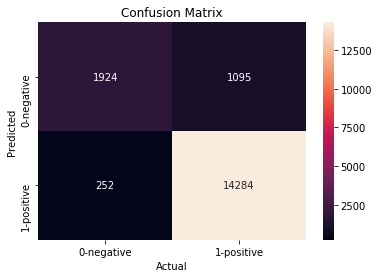

In [597]:
import seaborn as sb
C_tf = confusion_matrix(Y1_test,LogRt1.predict(X_test_tfidf))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_tf, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

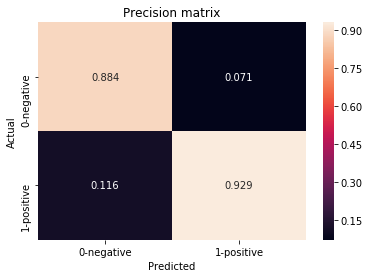

In [598]:
Bt =(C_tf/C_tf.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    Bt, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

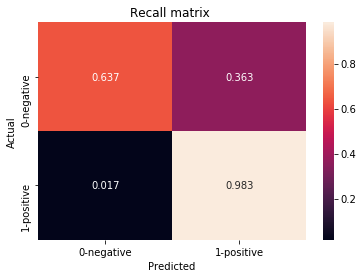

In [599]:
At =(((C_tf.T)/(C_tf.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    At, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## L2 regularization on TFIDF

C   log10(C) -----> CV AUC SCORE
----------------------------------------------------
1e-05   -5.0 -----> 0.91238234590016
0.0001   -4.0 -----> 0.9493544730382546
0.001   -3.0 -----> 0.9414450770485229
0.01   -2.0 -----> 0.9334456061036637
0.1   -1.0 -----> 0.9293931345936544
1   0.0 -----> 0.9262351023398249
10   1.0 -----> 0.9226221699273043
100   2.0 -----> 0.9215682424699518
1000   3.0 -----> 0.9211442627572262
10000   4.0 -----> 0.9211059322218776


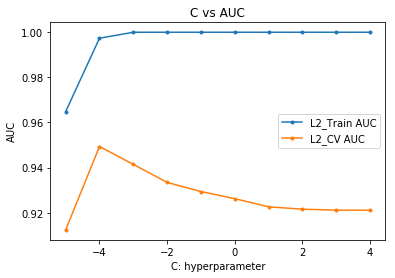

In [600]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score 
train_auc_l2 = [] 
cv_auc_l2 = []
print("C"," ","log10(C)","----->","CV AUC SCORE")
print("----------------------------------------------------")    

C=[10**i for i in range(-5,5)]
for j in C:
    LogRt2 = LogisticRegression(C=j, penalty= "l2")
    LogRt2.fit(X_train_tfidf, Y1_train)
    y_train_pred = LogRt2.predict_proba(X_train_tfidf)[:,1] 
    y_cv_pred =  LogRt2.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc_score=roc_auc_score(Y1_train,y_train_pred)
    train_auc_l2.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, y_cv_pred)
    print(j," ",np.log10(j),"----->",cv_auc_score)
    cv_auc_l2.append(cv_auc_score)
    
    
plt.plot(np.log10(C), train_auc_l2, label='L2_Train AUC',marker = '.') 
plt.plot(np.log10(C), cv_auc_l2, label='L2_CV AUC',marker = '.')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("C vs AUC")
plt.show()

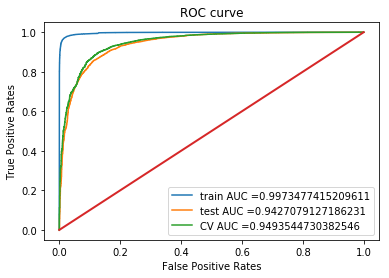

In [604]:
from sklearn.metrics import roc_curve, auc


LogRt3 = LogisticRegression(C=0.0001, penalty= "l2")
LogRt3.fit(X_train_tfidf, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(Y1_train, LogRt3.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, LogRt3.predict_proba(X_test_tfidf)[:,1])
cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,LogRt3.predict_proba(X_cv_tfidf)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

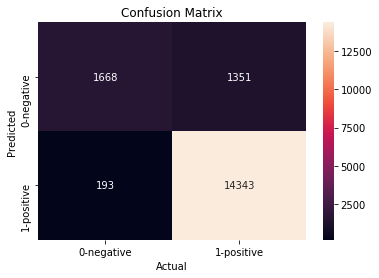

In [605]:
import seaborn as sb
C_tf1 = confusion_matrix(Y1_test,LogRt3.predict(X_test_tfidf))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_tf1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

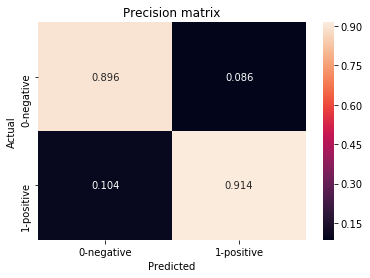

In [606]:
Bt1 =(C_tf1/C_tf1.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    Bt1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

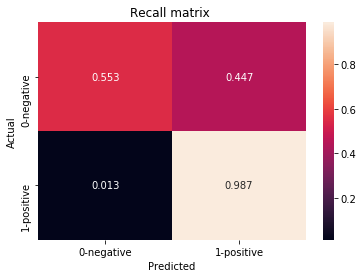

In [607]:
At1 =(((C_tf1.T)/(C_tf1.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    At1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Observations:<br>
1] For Tfidf L1 regularization we got Test Auc of 95.79.<br>
2] For L2 regularization we got Test Auc of 94.27.<br>

## Feature Importance on TFIDF

In [608]:
wht1=LogRt1.coef_
print(wht1.shape)

(1, 32777)


In [609]:
wh_12=np.argsort(wht1)
wh_12

array([[ 7281, 32308, 19145, ...,  6833,  2259, 12609]], dtype=int64)

In [610]:
wh_12[0][::-1]

array([12609,  2259,  6833, ..., 19145, 32308,  7281], dtype=int64)

In [611]:
wh_2=wh_12[0][::-1]

In [612]:
wh_2[:10]

array([12609,  2259,  6833, 12057, 16473, 16722, 21497,  8969, 32164,
       19302], dtype=int64)

In [613]:
featur_name=tf_idf_vect.get_feature_names()

## Top 10 important features of Positive class 

In [614]:
for i in wh_2[:10]:
    print("{0}   {1}".format(featur_name[i],wht1[0][i]))

great   0.6244981260445022
best   0.41634031446762865
delicious   0.40803646531512405
good   0.3879765479343734
love   0.3354728780987478
loves   0.3276064837873576
perfect   0.2910061605597767
excellent   0.24350993712203456
wonderful   0.21712399774555427
not disappointed   0.20593836006595825


## Top 10 important features of Negative class 

In [615]:
for i in wh_2[::-1][:10]:
    print("{0}   {1}".format(featur_name[i],wht1[0][i]))

disappointed   -0.26186026646923405
worst   -0.18817588388400783
not   -0.18393822366263976
not good   -0.15973533202222806
not recommend   -0.1515468941503331
not worth   -0.14789055057715159
awful   -0.13259959605984412
terrible   -0.13086375157631885
bad   -0.1287386775866827
two stars   -0.12278828691210374


## [3] AVERAGE W2V

In [106]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X1_train["UPDATEDTEXT"]:
    list_of_sentance_train.append(sentance.split())

In [107]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_cv=[]
for sentance in X1_cv["UPDATEDTEXT"]:
    list_of_sentance_cv.append(sentance.split())

In [108]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_test=[]
for sentance in X1_test["UPDATEDTEXT"]:
    list_of_sentance_test.append(sentance.split())

In [109]:
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


[('fantastic', 0.8371965885162354), ('awesome', 0.8308374881744385), ('good', 0.818211019039154), ('terrific', 0.808405876159668), ('excellent', 0.7958467602729797), ('perfect', 0.7699036598205566), ('wonderful', 0.7678007483482361), ('amazing', 0.7593561410903931), ('decent', 0.7257596850395203), ('nice', 0.7142620086669922)]
[('best', 0.7262170314788818), ('greatest', 0.6989122629165649), ('tastiest', 0.6938540935516357), ('experienced', 0.679233729839325), ('closest', 0.6549752354621887), ('disgusting', 0.6309447288513184), ('biggest', 0.6192417144775391), ('awful', 0.6007260084152222), ('sweetest', 0.5970974564552307), ('terrible', 0.5699278712272644)]


In [110]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14127
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'buggers', 'success', 'rate', 'day']


In [111]:
# Please write all the code with proper documentation
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 56174/56174 [01:27<00:00, 638.84it/s]


56174
50


In [112]:
# Please write all the code with proper documentation
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))



100%|███████████████████████████████████████████████████████████████████████████| 14044/14044 [00:22<00:00, 630.64it/s]


14044
50


In [113]:
# Please write all the code with proper documentation
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:30<00:00, 567.38it/s]


17555
50


## L1 regularization on Avg-W2V

C   log10(C) -----> CV AUC SCORE
----------------------------------------------------
1e-05   -5.0 -----> 0.5
0.0001   -4.0 -----> 0.5
0.001   -3.0 -----> 0.861165611026415
0.01   -2.0 -----> 0.8952981414305885
0.1   -1.0 -----> 0.8999912701574714
1   0.0 -----> 0.9005308905351668
10   1.0 -----> 0.9005793896603255
100   2.0 -----> 0.9005862047790281
1000   3.0 -----> 0.9005866374849775
10000   4.0 -----> 0.9005871423085849


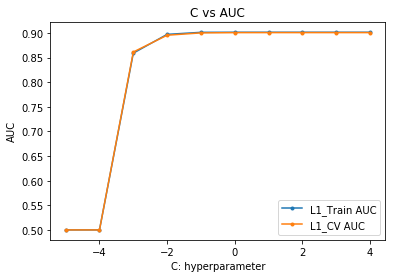

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score 
train_auc_l1 = [] 
cv_auc_l1 = []
print("C"," ","log10(C)","----->","CV AUC SCORE")
print("----------------------------------------------------")        

C=[10**i for i in range(-5,5)]
for j in C:
    LogRw = LogisticRegression(C=j, penalty= "l1")
    LogRw.fit(sent_vectors_train, Y1_train)
    y_train_pred = LogRw.predict_proba(sent_vectors_train)[:,1] 
    y_cv_pred =  LogRw.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc_score=roc_auc_score(Y1_train,y_train_pred)
    train_auc_l1.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, y_cv_pred)
    print(j," ",np.log10(j),"----->",cv_auc_score)
    cv_auc_l1.append(cv_auc_score)
    
    
plt.plot(np.log10(C), train_auc_l1, label='L1_Train AUC',marker = '.') 
plt.plot(np.log10(C), cv_auc_l1, label='L1_CV AUC',marker = '.')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("C vs AUC")
plt.show()

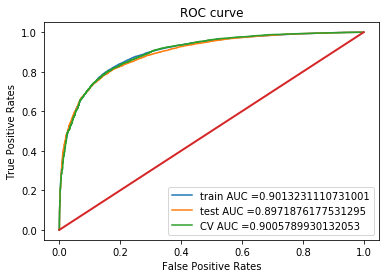

In [115]:
from sklearn.metrics import roc_curve, auc


LogRw2 = LogisticRegression(C=10, penalty= "l1")
LogRw2.fit(sent_vectors_train, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(Y1_train, LogRw2.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, LogRw2.predict_proba(sent_vectors_test)[:,1])
cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,LogRw2.predict_proba(sent_vectors_cv)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

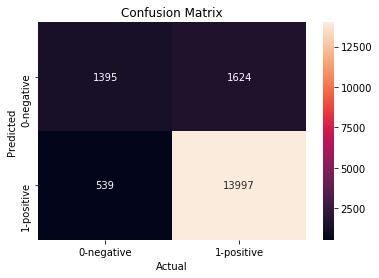

In [116]:
import seaborn as sb
C_av = confusion_matrix(Y1_test,LogRw2.predict(sent_vectors_test))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_av, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

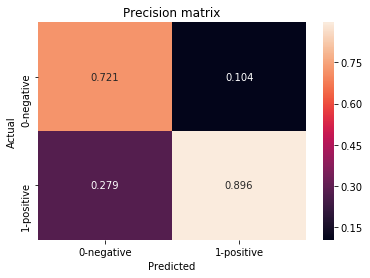

In [117]:
B_av =(C_av/C_av.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_av, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

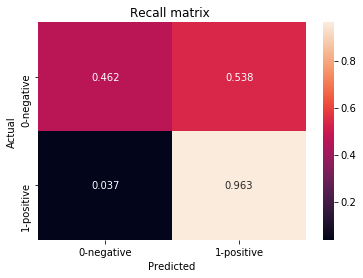

In [118]:
Av =(((C_av.T)/(C_av.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    Av, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## L2 regularization on Avg-W2V

C   log10(C) -----> CV AUC SCORE
----------------------------------------------------
1e-05   -5.0 -----> 0.6922491799230641
0.0001   -4.0 -----> 0.834980626853176
0.001   -3.0 -----> 0.8944101927636493
0.01   -2.0 -----> 0.9004594219358623
0.1   -1.0 -----> 0.9006787677933643
1   0.0 -----> 0.9005992220163384
10   1.0 -----> 0.9005898106619394
100   2.0 -----> 0.9005900630737432
1000   3.0 -----> 0.9005881519558002
10000   4.0 -----> 0.9005899188384269


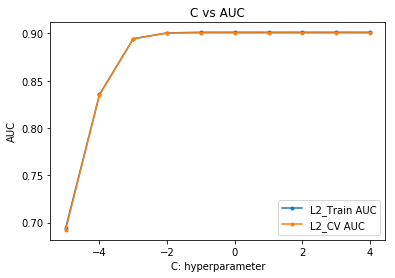

In [119]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score 
train_auc_l2 = [] 
cv_auc_l2 = []
print("C"," ","log10(C)","----->","CV AUC SCORE")
print("----------------------------------------------------")        

C=[10**i for i in range(-5,5)]
for j in C:
    LogRw2 = LogisticRegression(C=j, penalty= "l2")
    LogRw2.fit(sent_vectors_train, Y1_train)
    y_train_pred = LogRw2.predict_proba(sent_vectors_train)[:,1] 
    y_cv_pred =  LogRw2.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc_score=roc_auc_score(Y1_train,y_train_pred)
    train_auc_l2.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, y_cv_pred)
    print(j," ",np.log10(j),"----->",cv_auc_score)
    cv_auc_l2.append(cv_auc_score)
    
    
plt.plot(np.log10(C), train_auc_l2, label='L2_Train AUC',marker = '.') 
plt.plot(np.log10(C), cv_auc_l2, label='L2_CV AUC',marker = '.')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("C vs AUC")
plt.show()

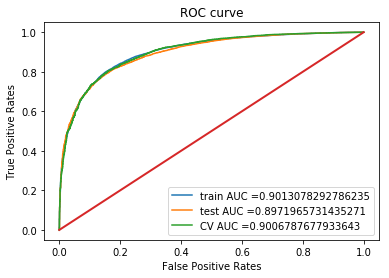

In [120]:
from sklearn.metrics import roc_curve, auc


LogRw2v = LogisticRegression(C=0.1, penalty= "l2")
LogRw2v.fit(sent_vectors_train, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(Y1_train, LogRw2v.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, LogRw2v.predict_proba(sent_vectors_test)[:,1])
cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,LogRw2v.predict_proba(sent_vectors_cv)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

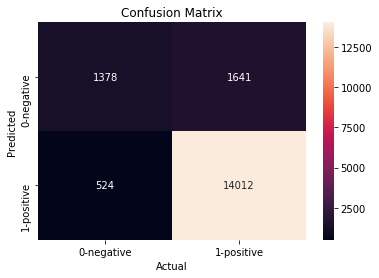

In [121]:
import seaborn as sb
C_avg = confusion_matrix(Y1_test,LogRw2v.predict(sent_vectors_test))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_avg, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

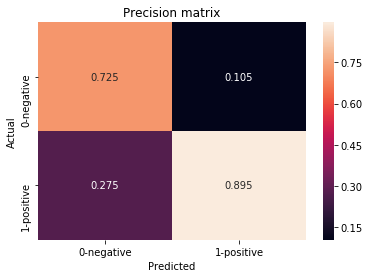

In [122]:
B_avg =(C_avg/C_avg.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_avg, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

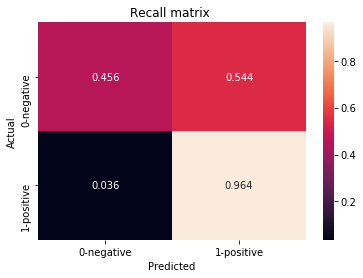

In [123]:
Avg =(((C_avg.T)/(C_avg.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    Avg, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Observations:<br>
1] For Avg W2V L1 regularization we got Test Auc of 89.718.<br>
2] For L2 regularization we got Test Auc of 89.719.<br>

## [4] TFIDF weighted W2V

In [87]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer(ngram_range = (1,2),min_df=10)
tf_idf_matrix = model.fit_transform(X1_train["UPDATEDTEXT"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [88]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1  

100%|████████████████████████████████████████████████████████████████████████████| 56174/56174 [20:58<00:00, 44.65it/s]


In [89]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1


100%|████████████████████████████████████████████████████████████████████████████| 14044/14044 [05:01<00:00, 46.52it/s]


In [90]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1


100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [06:57<00:00, 42.03it/s]


## L1 regularization on TFIDF weighted W2V

C   log10(C) -----> CV AUC SCORE
----------------------------------------------------
1e-05   -5.0 -----> 0.5
0.0001   -4.0 -----> 0.5
0.001   -3.0 -----> 0.8102437291983375
0.01   -2.0 -----> 0.8636257246427372
0.1   -1.0 -----> 0.8711909751674023
1   0.0 -----> 0.8717160277781354
10   1.0 -----> 0.8717460647827876
100   2.0 -----> 0.871750283665794
1000   3.0 -----> 0.8717462450769332
10000   4.0 -----> 0.8717694669628826


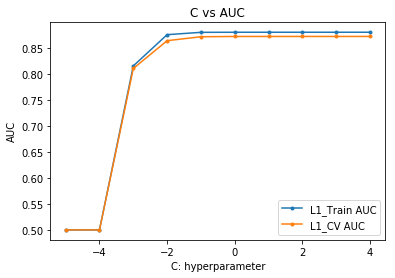

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score 
train_auc_l1 = [] 
cv_auc_l1 = []
print("C"," ","log10(C)","----->","CV AUC SCORE")
print("----------------------------------------------------")        

C=[10**i for i in range(-5,5)]
for j in C:
    LogRtw = LogisticRegression(C=j, penalty= "l1")
    LogRtw.fit(tfidf_sent_vectors_train, Y1_train)
    y_train_pred = LogRtw.predict_proba(tfidf_sent_vectors_train)[:,1] 
    y_cv_pred =  LogRtw.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc_score=roc_auc_score(Y1_train,y_train_pred)
    train_auc_l1.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, y_cv_pred)
    print(j," ",np.log10(j),"----->",cv_auc_score)
    cv_auc_l1.append(cv_auc_score)
    
    
plt.plot(np.log10(C), train_auc_l1, label='L1_Train AUC',marker = '.') 
plt.plot(np.log10(C), cv_auc_l1, label='L1_CV AUC',marker = '.')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("C vs AUC")
plt.show()

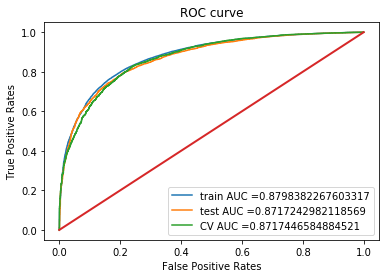

In [132]:
from sklearn.metrics import roc_curve, auc


LogRtw2v = LogisticRegression(C=10, penalty= "l1")
LogRtw2v.fit(tfidf_sent_vectors_train, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(Y1_train, LogRtw2v.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, LogRtw2v.predict_proba(tfidf_sent_vectors_test)[:,1])
cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,LogRtw2v.predict_proba(tfidf_sent_vectors_cv)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

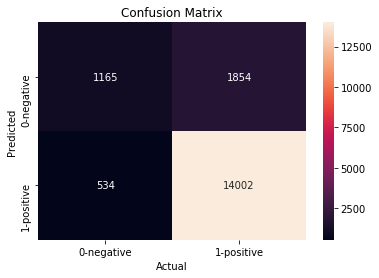

In [141]:
import seaborn as sb
C_tav = confusion_matrix(Y1_test,LogRtw2v.predict(tfidf_sent_vectors_test))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_tav, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

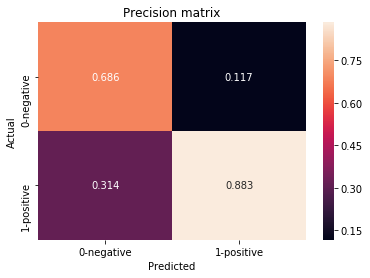

In [142]:
B_tav =(C_tav/C_tav.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_tav, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

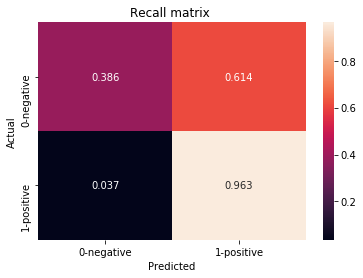

In [143]:
Avt =(((C_tav.T)/(C_tav.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    Avt, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## L2 regularization on TFIDF weighted W2V

C   log10(C) -----> CV AUC SCORE
----------------------------------------------------
1e-05   -5.0 -----> 0.6752025848122591
0.0001   -4.0 -----> 0.8054731100476882
0.001   -3.0 -----> 0.864269915624864
0.01   -2.0 -----> 0.8710266190242992
0.1   -1.0 -----> 0.8717742988459841
1   0.0 -----> 0.8717641302561738
10   1.0 -----> 0.8717581084317116
100   2.0 -----> 0.8717560891372814
1000   3.0 -----> 0.8717554761371864
10000   4.0 -----> 0.8717554400783574


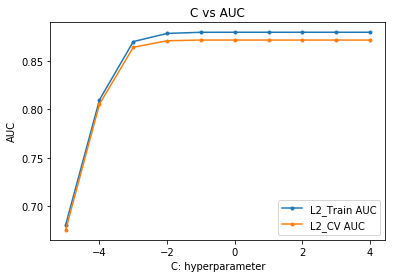

In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score 
train_auc_l2 = [] 
cv_auc_l2 = []
print("C"," ","log10(C)","----->","CV AUC SCORE")
print("----------------------------------------------------")        

C=[10**i for i in range(-5,5)]
for j in C:
    Logw2v = LogisticRegression(C=j, penalty= "l2")
    Logw2v.fit(tfidf_sent_vectors_train, Y1_train)
    y_train_pred = Logw2v.predict_proba(tfidf_sent_vectors_train)[:,1] 
    y_cv_pred =  Logw2v.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc_score=roc_auc_score(Y1_train,y_train_pred)
    train_auc_l2.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, y_cv_pred)
    print(j," ",np.log10(j),"----->",cv_auc_score)
    cv_auc_l2.append(cv_auc_score)
    
    
plt.plot(np.log10(C), train_auc_l2, label='L2_Train AUC',marker = '.') 
plt.plot(np.log10(C), cv_auc_l2, label='L2_CV AUC',marker = '.')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("C vs AUC")
plt.show()

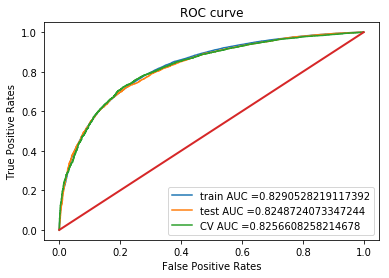

In [137]:
from sklearn.metrics import roc_curve, auc


Low2v = LogisticRegression(C=0.1, penalty= "l2")
Low2v.fit(sent_vectors_train, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(Y1_train, Low2v.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, Low2v.predict_proba(tfidf_sent_vectors_test)[:,1])
cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,Low2v.predict_proba(tfidf_sent_vectors_cv)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=2.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()

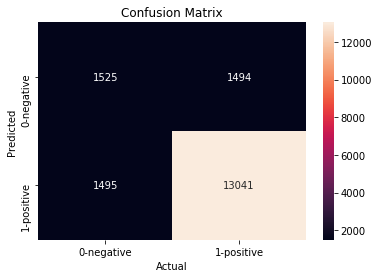

In [138]:
import seaborn as sb
C_vg = confusion_matrix(Y1_test,Low2v.predict(tfidf_sent_vectors_test))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_vg, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

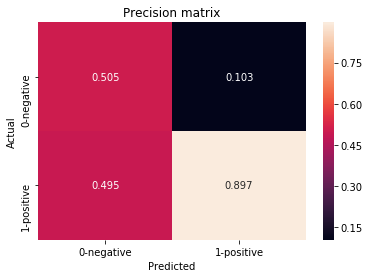

In [139]:
B_vg =(C_vg/C_vg.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_vg, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

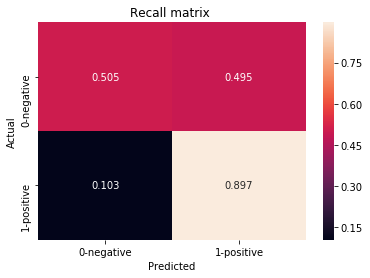

In [140]:
Ag =(((C_vg.T)/(C_vg.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    Ag, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Observations:<br>
1] For Tfiidf W2V L1 regularization we got Test Auc of 87.17.<br>
2] For L2 regularization we got Test Auc of 82.48.<br>

## CONCLUSIONS:

In [158]:
from prettytable import PrettyTable
    
x = PrettyTable(["Vectorizer", "Regularization", "Best Hyperparameter","AUC score"])
x.align["Vectorizer"] = "l"
x.add_row(["BOW"," L1 \n L2 \n ------------","0.01\n0.001\n -----------","94.96\n93.07\n ----------"])
x.add_row(["tfidf"," L1 \n L2 \n ------------","0.01\n0.0001\n -----------","95.79\n94.27\n ----------"])
x.add_row(["Average w2v"," L1 \n L2 \n ------------","10\n0.1\n -----------","89.719\n89.719\n -----------"])
x.add_row(["Tfidf w2v"," L1 \n L2 \n","10\n0.1","87.17\n82.48"])

print(x.get_string(title="KNN ON DIFFERENT FEATURIZATION"))

+-------------------------------------------------------------------+
|                   KNN ON DIFFERENT FEATURIZATION                  |
+-------------+----------------+---------------------+--------------+
| Vectorizer  | Regularization | Best Hyperparameter |  AUC score   |
+-------------+----------------+---------------------+--------------+
| BOW         |       L1       |         0.01        |    94.96     |
|             |       L2       |        0.001        |    93.07     |
|             |  ------------  |      -----------    |  ----------  |
| tfidf       |       L1       |         0.01        |    95.79     |
|             |       L2       |        0.0001       |    94.27     |
|             |  ------------  |      -----------    |  ----------  |
| Average w2v |       L1       |          10         |    89.719    |
|             |       L2       |         0.1         |    89.719    |
|             |  ------------  |      -----------    |  ----------- |
| Tfidf w2v   |     

1] After applying logistic regression on tfidf we get the best test AUC of 95.79.<br>
2] L1 regularization has performed better on all the featurization.<br>
3] We got Test Auc of 87.17 for tfidf w2v which is least auc among all featurization.<br>